In [8]:
df = pd.read_csv(r'C:\Users\Lavanyabh\Desktop\Sem3\project\dataset.csv',compression='gzip')
df.head(5)

,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,"c(""blueberries"", ""granulated sugar"", ""vanilla ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,41,Carina's Tofu-Vegetable Kebabs,20,1440,1460,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,"c(""Drain the tofu, carefully squeezing out exc..."
2,42,Cabbage Soup,30,20,50,"c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,"c(""Mix everything together and bring to a boil..."
3,45,Buttermilk Pie With Gingersnap Crumb Crust,50,30,80,"c(""sugar"", ""margarine"", ""egg"", ""flour"", ""salt""...",228.0,7.1,1.7,24.5,281.8,37.5,0.5,24.7,4.2,"c(""Preheat oven to 350°F."", ""Make pie crust, u..."
4,46,A Jad - Cucumber Pickle,0,25,25,"c(""rice vinegar"", ""haeo"")",4.3,0.0,0.0,0.0,0.7,1.1,0.2,0.2,0.1,"c(""Slice the cucumber in four lengthwise, then..."


In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Define functions for recommendation system

def scaling(dataframe):
    # Scaling numerical columns in the dataframe
    scaler = StandardScaler()
    prep_data = scaler.fit_transform(dataframe.iloc[:, 6:15].to_numpy())  # Assuming columns 6 to 15 are numerical
    return prep_data, scaler

def nn_predictor(prep_data):
    neigh = NearestNeighbors(metric='cosine', algorithm='brute')
    neigh.fit(prep_data)
    return neigh

def build_pipeline(neigh, scaler, params):
    transformer = FunctionTransformer(neigh.kneighbors, kw_args=params)
    pipeline = Pipeline([('std_scaler', scaler), ('NN', transformer)])
    return pipeline

def extract_ingredient_filtered_data(dataframe, ingredients):
    # Filter recipes based on the ingredients
    extracted_data = dataframe.copy()
    regex_string = ''.join(map(lambda x: f'(?=.*{x})', ingredients))
    extracted_data = extracted_data[extracted_data['RecipeIngredientParts'].str.contains(regex_string, regex=True, flags=re.IGNORECASE)]
    return extracted_data

def apply_pipeline(pipeline, _input, extracted_data, scaler, neigh, params):
    # Reshape input and apply the pipeline
    _input = np.array(_input).reshape(1, -1)
    _input_scaled = scaler.transform(_input)  # Scale the input
    distances, indices = neigh.kneighbors(_input_scaled, n_neighbors=params['n_neighbors'])
    return extracted_data.iloc[indices[0]]

def recommend(dataframe, _input, ingredients=[], params={'n_neighbors': 5, 'return_distance': False}):
    # Filter recipes based on ingredients and apply the recommendation system
    extracted_data = extract_ingredient_filtered_data(dataframe, ingredients)
    if extracted_data.shape[0] >= params['n_neighbors']:
        prep_data, scaler = scaling(extracted_data)
        neigh = nn_predictor(prep_data)
        return apply_pipeline(neigh, _input, extracted_data, scaler, neigh, params)
    else:
        return None

def extract_quoted_strings(s):
    # Extract strings inside double quotes from a string (without 'c("...")' format)
    strings = re.findall(r'"([^"]*)"', s)
    return strings

def output_recommended_recipes(dataframe):
    if dataframe is not None:
        output = dataframe.copy()
        output = output.to_dict("records")
        for recipe in output:
            recipe['RecipeIngredientParts'] = ', '.join(extract_quoted_strings(recipe['RecipeIngredientParts']))  # Clean output
            recipe['RecipeInstructions'] = ', '.join(extract_quoted_strings(recipe['RecipeInstructions']))  # Clean output
    else:
        output = None
    return output


Enter your age: 21
Enter your height (in cm): 157
Enter your weight (in kg): 55
Enter your goal (weight loss, muscle gain, maintenance, weight gain): weight loss
Enter your diet preference (veg, non-veg, or mixed): veg
Would you like to apply additional filters? (yes/no): yes
Enter ingredients to exclude (comma-separated): potato,tomato

Your BMI is: 22.31

Suggested Action: You're at a normal weight. Maintain your weight with balanced meals and regular exercise. Keep up the great work maintaining a healthy lifestyle!

Top 5 Recommended Recipes:

----- Recipe #1 -----
Name: Feijoada (Brazilian Bean Soup)
  - Calories: 286.9
  - Protein: 16.6g
  - Ingredients:
    * dried black beans
    * onions
    * turkey Polish kielbasa
    * turkey Polish kielbasa
    * garlic
    * cumin
    * water
    * salt
    * pepper
    * bay leaf
    * red wine vinegar
  - Instructions:
    Step 1: Sort and wash beans; place in a large Dutch oven."
    Step 2: "Cover with water to 2 inches above beans, an

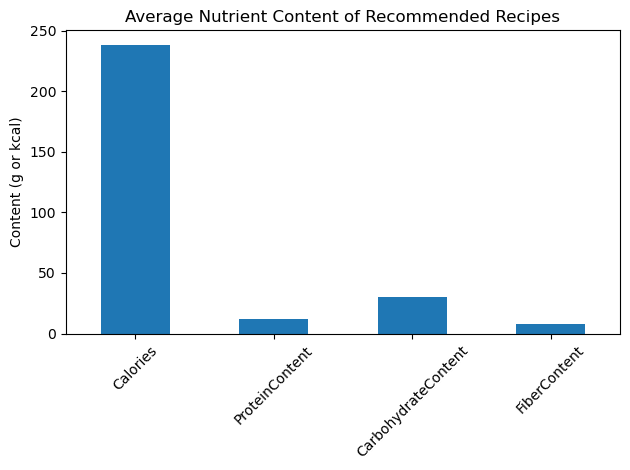


The best recipe for your goal is: Acadia's French Green Beans

Would you like to save your preferences for next time? (yes/no): yes

Your preferences have been saved!


In [10]:
# user_inputs.py

def get_user_inputs():
    """Handles user input for age, height, weight, goal, and diet preference."""
    while True:
        try:
            age = int(input("Enter your age: "))
            if age <= 0:
                raise ValueError("Age must be a positive integer.")
            break
        except ValueError as e:
            print(f"Invalid input for age: {e}. Please enter a valid integer.")

    while True:
        try:
            height = float(input("Enter your height (in cm): "))
            if height <= 0:
                raise ValueError("Height must be a positive number.")
            break
        except ValueError as e:
            print(f"Invalid input for height: {e}. Please enter a valid float.")

    while True:
        try:
            weight = float(input("Enter your weight (in kg): "))
            if weight <= 0:
                raise ValueError("Weight must be a positive number.")
            break
        except ValueError as e:
            print(f"Invalid input for weight: {e}. Please enter a valid float.")

    while True:
        goal = input("Enter your goal (weight loss, muscle gain, maintenance, weight gain): ").lower()
        if goal in ['weight loss', 'muscle gain', 'maintenance', 'weight gain']:
            break
        else:
            print("Invalid goal. Please enter one of the following: weight loss, muscle gain, maintenance, weight gain.")

    while True:
        diet_preference = input("Enter your diet preference (veg, non-veg, or mixed): ").lower()
        if diet_preference in ['veg', 'non-veg', 'mixed']:
            break
        else:
            print("Invalid diet preference. Please enter one of the following: veg, non-veg, mixed.")

    # Optional filters
    filter_option = input("Would you like to apply additional filters? (yes/no): ").lower()
    exclude_ingredients = []
    if filter_option == 'yes':
        exclude_input = input("Enter ingredients to exclude (comma-separated): ")
        exclude_ingredients = [ing.strip() for ing in exclude_input.split(',') if ing.strip()]

    return age, height, weight, goal, diet_preference, exclude_ingredients

# recipe_filter.py

import pandas as pd
import re

def filter_recipes(df, bmi, goal, diet_preference, exclude_ingredients=[]):
    """Filters recipes based on BMI, goal, diet preference, and optional filters."""
    non_veg_keywords = ['chicken', 'beef', 'fish', 'pork', 'egg', 'shrimp', 'lobster', 'bacon', 'ham', 'clams', 'crab', 'duck', 'turkey', 'lamb', 'goat', 'mutton']
    veg_keywords = ['tofu', 'lentil', 'vegetable', 'beans', 'quinoa']

    recommended_recipes = pd.DataFrame()  # Initialize empty DataFrame for recommendations
    action = ""

    # BMI-based action suggestions
    if bmi < 18.5:  # Underweight
        recommended_recipes = df[(df['Calories'] > 300) & (df['FiberContent'] > 5) & (df['CarbohydrateContent'] > 30)]
        action = "You're underweight. Focus on gaining weight by consuming calorie-dense, nutritious foods. Small steps matter! Celebrate every meal as progress."
    elif 18.5 <= bmi <= 24.9:  # Normal weight
        recommended_recipes = df[(df['Calories'] < 400) & (df['FiberContent'] > 4) & (df['CarbohydrateContent'] < 50)]
        action = "You're at a normal weight. Maintain your weight with balanced meals and regular exercise. Keep up the great work maintaining a healthy lifestyle!"
    else:  # Overweight
        recommended_recipes = df[(df['Calories'] < 250) & (df['FiberContent'] > 5) & (df['CarbohydrateContent'] < 30)]
        action = "You're overweight. Focus on weight loss by consuming low-calorie, high-fiber foods. You're taking a positive step toward a healthier you!"

    # If the goal is muscle gain, recommend higher-protein, calorie-dense foods
    if goal == 'muscle gain':
        recommended_recipes = df[(df['ProteinContent'] > 20) & (df['Calories'] > 400) & (df['CarbohydrateContent'] > 40)]
        action = "You're aiming for muscle gain. Focus on high-protein, calorie-dense foods to build muscle. Remember, every rep and every meal counts towards your strength!"

    # Filter by diet preference (veg, non-veg, mixed)
    if diet_preference == 'veg':
        recommended_recipes = recommended_recipes[recommended_recipes['RecipeIngredientParts'].str.contains('|'.join(veg_keywords), case=False)]
    elif diet_preference == 'non-veg':
        recommended_recipes = recommended_recipes[recommended_recipes['RecipeIngredientParts'].str.contains('|'.join(non_veg_keywords), case=False)]

    # Exclude specified ingredients
    if exclude_ingredients:
        exclude_pattern = '|'.join(exclude_ingredients)
        recommended_recipes = recommended_recipes[~recommended_recipes['RecipeIngredientParts'].str.contains(exclude_pattern, case=False)]

    
    return recommended_recipes, action

def display_recipes(recommended_recipes, action):
    """Displays recipes with improved readability and separation."""
    if recommended_recipes.empty:
        print("\nNo recommended recipes based on your preferences.")
    else:
        print(f"\nSuggested Action: {action}\n")
        print("Top 5 Recommended Recipes:")
        for idx, recipe in enumerate(recommended_recipes.head(5).itertuples(), 1):
            print(f"\n----- Recipe #{idx} -----")
            print(f"Name: {recipe.Name}")
            print(f"  - Calories: {recipe.Calories}")
            print(f"  - Protein: {recipe.ProteinContent}g")
            print("  - Ingredients:")
            ingredients = re.findall(r'"([^"]*)"', recipe.RecipeIngredientParts)
            for ingredient in ingredients:
                print(f"    * {ingredient}")

            print("  - Instructions:")
            steps = re.split(r'(?<!\w),(?!\w)', recipe.RecipeInstructions)  # Split by commas not in words
            for i, step in enumerate(steps, 1):
                step = step.strip()
                # Remove any erroneous characters (like 'c("')
                step = re.sub(r'^[a-zA-Z]*\("?', '', step)
                step = re.sub(r'"?\)$', '', step)
                
                if step.lower().startswith("note"):
                    print(f"    NOTE: {step}")
                elif step:
                    print(f"    Step {i}: {step}")

# Define function to compare recipes visually
def plot_comparison_of_recipes(recipes):
    if not recipes.empty:
        nutrients = recipes[['Calories', 'ProteinContent', 'CarbohydrateContent', 'FiberContent']]
        nutrients.plot(kind='bar', figsize=(10, 6))
        plt.title('Comparison of Top 5 Recipes')
        plt.xlabel('Recipe')
        plt.ylabel('Nutrient Content')
        plt.tight_layout()
        st.pyplot(plt)
        
def plot_recipe_nutrients(recipes):
    """Visualize the average nutrient content of the top recommended recipes."""
    if not recipes.empty:
        nutrients = recipes[['Calories', 'ProteinContent', 'CarbohydrateContent', 'FiberContent']]
        # Calculate the average nutrient content for the recommended recipes
        nutrients_mean = nutrients.mean()
        nutrients_mean.plot(kind='bar', title='Average Nutrient Content of Recommended Recipes')
        plt.ylabel('Content (g or kcal)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def select_best_recipe(recommended_recipes, goal):
    """Select the best recipe based on the user's goal."""
    if recommended_recipes.empty:
        return None

    if goal == 'weight loss':
        # Sort by calories (lower calories are better for weight loss)
        best_recipe = recommended_recipes.sort_values(by='Calories').iloc[0]
    elif goal == 'muscle gain':
        # Sort by protein content (higher protein is better for muscle gain)
        best_recipe = recommended_recipes.sort_values(by='ProteinContent', ascending=False).iloc[0]
    else:
        # If goal is maintenance or other, select a balanced recipe
        best_recipe = recommended_recipes.sort_values(by=['Calories', 'ProteinContent']).iloc[0]

    return best_recipe
import json


def save_user_preferences(age, height, weight, goal, diet_preference, exclude_ingredients):
    """Save user preferences to a file."""
    user_preferences = {
        'age': age,
        'height': height,
        'weight': weight,
        'goal': goal,
        'diet_preference': diet_preference,
        'exclude_ingredients': exclude_ingredients
    }
    
    with open('user_preferences.json', 'w') as f:
        json.dump(user_preferences, f)
    print("\nYour preferences have been saved!")

def load_user_preferences():
    """Load user preferences from a file."""
    try:
        with open('user_preferences.json', 'r') as f:
            preferences = json.load(f)
        return preferences
    except FileNotFoundError:
        print("No saved preferences found.")
        return None
    
def display_recipes_with_feedback(recommended_recipes, action):
    """Display recipes with feedback when no recommendations are found."""
    if recommended_recipes.empty:
        print("\nNo recommended recipes based on your preferences.")
        print("Consider relaxing your filters or adjusting your goal/diet preference.")
    else:
        print(f"\nSuggested Action: {action}\n")
        print("Top 5 Recommended Recipes:")
        for idx, recipe in enumerate(recommended_recipes.head(5).itertuples(), 1):
            print(f"\n----- Recipe #{idx} -----")
            print(f"Name: {recipe.Name}")
            print(f"  - Calories: {recipe.Calories}")
            print(f"  - Protein: {recipe.ProteinContent}g")
            print("  - Ingredients:")
            ingredients = re.findall(r'"([^"]*)"', recipe.RecipeIngredientParts)
            for ingredient in ingredients:
                print(f"    * {ingredient}")

            print("  - Instructions:")
            steps = re.split(r'(?<!\w),(?!\w)', recipe.RecipeInstructions)  # Split by commas not in words
            for i, step in enumerate(steps, 1):
                step = step.strip()
                # Remove any erroneous characters (like 'c("')
                step = re.sub(r'^[a-zA-Z]*\("?', '', step)
                step = re.sub(r'"?\)$', '', step)
                
                if step.lower().startswith("note"):
                    print(f"    NOTE: {step}")
                elif step:
                    print(f"    Step {i}: {step}")


def main():
    df = pd.read_csv(r'C:\Users\Lavanyabh\Desktop\Sem3\project\dataset.csv',compression='gzip')
    age, height, weight, goal, diet_preference, exclude_ingredients = get_user_inputs()
    bmi = weight / ((height / 100) ** 2)
    print(f"\nYour BMI is: {bmi:.2f}")

    recommended_recipes, action = filter_recipes(
        df, bmi, goal, diet_preference, exclude_ingredients
    )
    
    display_recipes_with_feedback(recommended_recipes, action)
    
    # Show the average nutrient content of the top recommended recipes
    plot_recipe_nutrients(recommended_recipes)
    
    # Select the best recipe for the user
    best_recipe = select_best_recipe(recommended_recipes, goal)
    if best_recipe is not None:
        print(f"\nThe best recipe for your goal is: {best_recipe.Name}")
    
    # Save preferences if the user wants to
    save_option = input("\nWould you like to save your preferences for next time? (yes/no): ").lower()
    if save_option == 'yes':
        save_user_preferences(age, height, weight, goal, diet_preference, exclude_ingredients)

if __name__ == "__main__":
    main()


In [11]:
!pip install streamlit

In [15]:
%%writefile diet_recommendation_app.py
import streamlit as st
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Function definitions
def scaling(dataframe):
    scaler = StandardScaler()
    prep_data = scaler.fit_transform(dataframe.iloc[:, 6:15].to_numpy())
    return prep_data, scaler

def nn_predictor(prep_data):
    neigh = NearestNeighbors(metric='cosine', algorithm='brute')
    neigh.fit(prep_data)
    return neigh

def filter_recipes(df, bmi, goal, diet_preference, exclude_ingredients=[]):
    non_veg_keywords = ['chicken', 'beef', 'fish', 'pork', 'egg', 'shrimp', 'lobster']
    veg_keywords = ['tofu', 'lentil', 'vegetable', 'beans', 'quinoa']

    recommended_recipes = pd.DataFrame()  
    if bmi < 18.5:  # Underweight
        recommended_recipes = df[(df['Calories'] > 300) & (df['FiberContent'] > 5)]
    elif 18.5 <= bmi <= 24.9:  # Normal
        recommended_recipes = df[(df['Calories'] < 400) & (df['FiberContent'] > 4)]
    else:  # Overweight
        recommended_recipes = df[(df['Calories'] < 250) & (df['FiberContent'] > 5)]

    if goal == 'muscle gain':
        recommended_recipes = recommended_recipes[(recommended_recipes['ProteinContent'] > 20) & (recommended_recipes['Calories'] > 400)]

    if diet_preference == 'veg':
        recommended_recipes = recommended_recipes[recommended_recipes['RecipeIngredientParts'].str.contains('|'.join(veg_keywords), case=False)]
    elif diet_preference == 'non-veg':
        recommended_recipes = recommended_recipes[recommended_recipes['RecipeIngredientParts'].str.contains('|'.join(non_veg_keywords), case=False)]

    if exclude_ingredients:
        exclude_pattern = '|'.join(exclude_ingredients)
        recommended_recipes = recommended_recipes[~recommended_recipes['RecipeIngredientParts'].str.contains(exclude_pattern, case=False)]

    return recommended_recipes

def calculate_bmi(weight, height):
    return weight / ((height / 100) ** 2)

def suggest_action(bmi):
    if bmi < 18.5:
        return "You're underweight. Focus on gaining weight by consuming calorie-dense, nutritious foods."
    elif 18.5 <= bmi <= 24.9:
        return "You're at a normal weight. Maintain your weight with balanced meals and regular exercise."
    else:
        return "You're overweight. Focus on weight loss by consuming low-calorie, high-fiber foods."

def clean_instructions(instructions):
    steps = re.split(r'(?<!\w),(?!\w)', instructions)
    cleaned_steps = [step.replace('c("', '').replace('"', '').replace('")', '').strip() for step in steps if step.strip()]
    return cleaned_steps

def display_recipes(recommended_recipes):
    if recommended_recipes.empty:
        st.write("No recommended recipes based on your preferences.")
    else:
        st.write("**Top 5 Recommended Recipes:**")
        for idx, recipe in enumerate(recommended_recipes.head(5).itertuples(), 1):
            st.write(f"### Recipe #{idx}: {recipe.Name}")
            st.write(f"- **Calories:** {recipe.Calories} kcal")
            st.write(f"- **Protein:** {recipe.ProteinContent}g")
            st.write(f"- **Carbs:** {recipe.CarbohydrateContent}g")
            st.write(f"- **Fiber:** {recipe.FiberContent}g")

            with st.expander(f"Ingredients for {recipe.Name}"):
                ingredients = re.findall(r'"([^"]*)"', recipe.RecipeIngredientParts)
                for ingredient in ingredients:
                    st.write(f"  - {ingredient}")

            with st.expander(f"Instructions for {recipe.Name}"):
                steps = clean_instructions(recipe.RecipeInstructions)
                for i, step in enumerate(steps, 1):
                    st.write(f"  **Step {i}:** {step}")

def best_recipe_chart(recipe):
    st.write("### Nutritional Breakdown of Best Recipe")
    labels = ['Calories', 'Protein', 'Carbohydrates', 'Fiber']
    values = [recipe.Calories, recipe.ProteinContent, recipe.CarbohydrateContent, recipe.FiberContent]

    # Creating the pie chart with Plotly
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=values,
        textinfo='label+percent',
        insidetextorientation='radial',
        hoverinfo='label+percent+value',
        hole=0.3,  # Donut chart
        marker=dict(
            colors=['#FFB6C1', '#FFFF99', '#E6E6FA', '#F08080'],  # Soft pastel colors
            line=dict(color='#FFFFFF', width=2),  # White borders around segments
        ),
        textfont=dict(size=14, color='#D3D3D3'),  # Light grey label text for dark mode
    )])

    # Update layout with improved title, legend, and overall design
    fig.update_layout(
        title_text="Nutritional Composition (Best Recipe)",
        title_font=dict(size=20, color='#FFFFFF'),  # White title for dark mode
        legend=dict(x=0.8, y=1, font=dict(size=12, color='#D3D3D3')),  # Light grey legend text
        margin=dict(l=50, r=50, t=50, b=50),  # Add some margin around the chart
        height=450,
        showlegend=True
    )

    # Show the figure
    st.plotly_chart(fig)

def save_user_preferences(age, height, weight, goal, diet_preference, exclude_ingredients):
    user_preferences = {
        'age': age,
        'height': height,
        'weight': weight,
        'goal': goal,
        'diet_preference': diet_preference,
        'exclude_ingredients': exclude_ingredients
    }
    with open('user_preferences.json', 'w') as f:
        json.dump(user_preferences, f)

def score_recipe(recipe, bmi, goal):
    # Initial score is 0
    score = 0
    
    # Higher protein is better for muscle gain
    score += recipe.ProteinContent * 2 if goal == "muscle gain" else recipe.ProteinContent
    
    # Lower calories are better for weight loss and higher for weight gain
    if goal == "weight loss":
        score -= recipe.Calories * 0.5
    elif goal == "weight gain":
        score += recipe.Calories * 0.5
    
    # Favor recipes with higher fiber content (important for digestion and weight loss)
    score += recipe.FiberContent * 1.5

    # If the recipe has a good balance of carbs, we give it a higher score
    score += recipe.CarbohydrateContent * 0.5

    return score

def best_recipe(recommended_recipes, bmi, goal):
    # Calculate the score for each recipe
    recommended_recipes['Score'] = recommended_recipes.apply(lambda row: score_recipe(row, bmi, goal), axis=1)
    
    # Sort the recipes by score and pick the best one
    best_recipe = recommended_recipes.sort_values(by='Score', ascending=False).iloc[0]
    return best_recipe

def display_best_recipe(best_recipe):
    # Display the best recipe
    st.write(f"## Best Recipe: **{best_recipe.Name}**")
    st.write(f"- **Calories:** {best_recipe.Calories} kcal")
    st.write(f"- **Protein:** {best_recipe.ProteinContent}g")
    st.write(f"- **Carbs:** {best_recipe.CarbohydrateContent}g")
    st.write(f"- **Fiber:** {best_recipe.FiberContent}g")
    
    # Chart for the nutritional breakdown
    best_recipe_chart(best_recipe)

    # Display the recipe ingredients and instructions
    with st.expander(f"Ingredients for {best_recipe.Name}"):
        ingredients = re.findall(r'"([^"]*)"', best_recipe.RecipeIngredientParts)
        for ingredient in ingredients:
            st.write(f"  - {ingredient}")

    with st.expander(f"Instructions for {best_recipe.Name}"):
        steps = clean_instructions(best_recipe.RecipeInstructions)
        for i, step in enumerate(steps, 1):
            st.write(f"  **Step {i}:** {step}")

def main():
    st.title("Personalized Diet Recommendation System")

    # User input section
    age = int(st.number_input("Enter your age", min_value=1, step=1))
    height = float(st.number_input("Enter your height (in cm)", min_value=50.0, step=0.1))
    weight = float(st.number_input("Enter your weight (in kg)", min_value=30.0, step=0.1))
    goal = st.selectbox("Select your goal", ["weight loss", "muscle gain", "maintenance", "weight gain"])
    diet_preference = st.selectbox("Select your diet preference", ["veg", "non-veg", "mixed"])
    exclude_ingredients = [ingredient.strip() for ingredient in st.text_area("Enter ingredients to exclude (comma-separated)", "").split(',') if ingredient.strip()]

    if st.button("Get Recommendations"):
        # BMI Calculation and Action Suggestion
        bmi = calculate_bmi(weight, height)
        action = suggest_action(bmi)

        st.markdown(f"<h2 style='color: #FF6347; font-weight: bold;'>Your BMI is: {bmi:.2f}</h2>", unsafe_allow_html=True)
        st.markdown(f"<h3 style='color: #32CD32; font-size: 18px;'>{action}</h3>", unsafe_allow_html=True)

        try:
            df = pd.read_csv(r'C:\Users\Lavanyabh\Desktop\Sem3\project\dataset.csv', compression='gzip')
        except FileNotFoundError:
            st.error("Dataset not found. Please check the file path.")
            return

        # Filter recipes
        recommended_recipes = filter_recipes(df, bmi, goal, diet_preference, exclude_ingredients)
        display_recipes(recommended_recipes)

        # Highlight the best recipe
        if not recommended_recipes.empty:
            best_recipe_ = best_recipe(recommended_recipes, bmi, goal)
            display_best_recipe(best_recipe_)

            # Provide the option to download the recipes
            csv = recommended_recipes.to_csv(index=False)
            st.download_button(
                label="Download Recommended Recipes",
                data=csv,
                file_name="recommended_recipes.csv",
                mime="text/csv"
            )

        # Save user preferences
        save_user_preferences(age, height, weight, goal, diet_preference, exclude_ingredients)

if __name__ == "__main__":
    main()


Overwriting diet_recommendation_app.py


In [9]:
#in cmd

In [6]:
import os
print(os.getcwd())


C:\Users\Lavanyabh\Project_sem_3


In [ ]:
streamlit run diet_recommendation_app.py